사용할 장치: cuda
클래스 이름: ['maximal', 'minimal']
전체 이미지 수: 200개
학습 데이터 수: 160개
검증 데이터 수: 40개


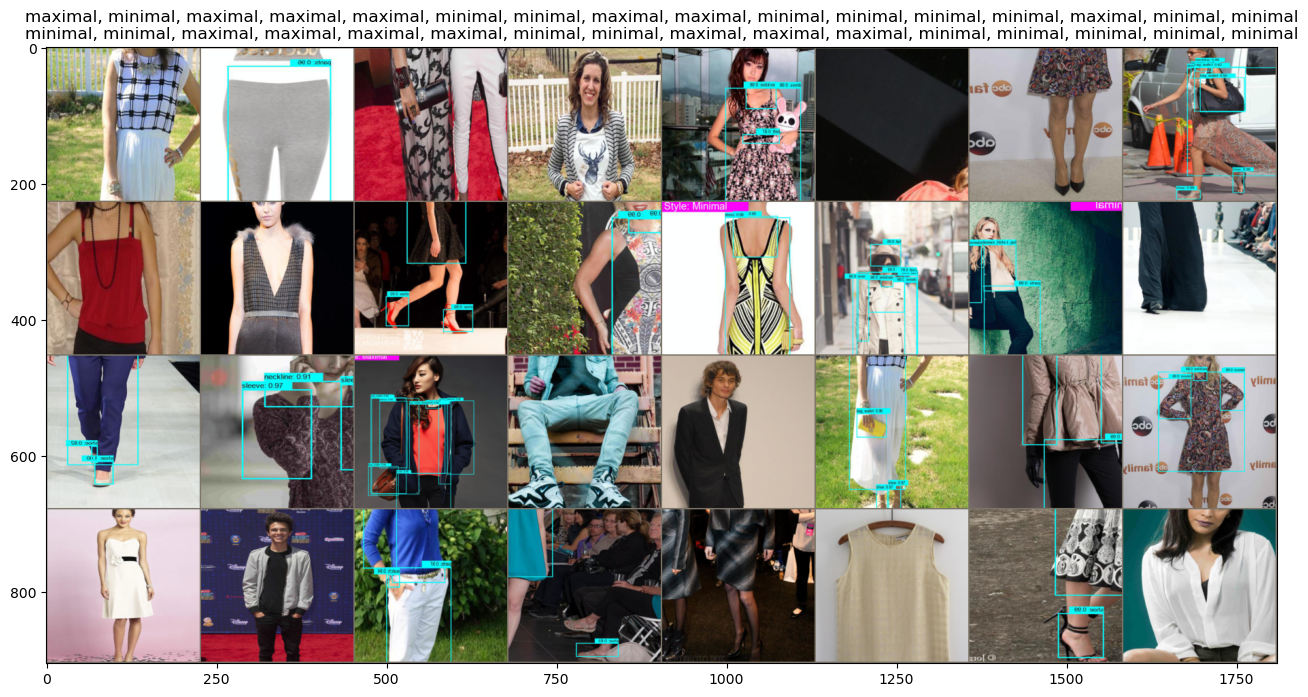

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import os
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 기본 설정 및 데이터 경로 정의 ---
# 작업 폴더 안에 있는 'minimal', 'maximal' 폴더를 사용합니다.
data_dir = './dataset'
# CUDA 사용 가능 여부 확인 (GPU가 있으면 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용할 장치: {device}")


# --- 2. 데이터 전처리 및 증강(Augmentation) 설정 ---
# 이미지를 224x224 크기로 맞추고, 텐서로 변환하며, 정규화합니다.
# 학습(train) 데이터는 약간의 변형(뒤집기 등)을 주어 모델이 다양한 상황에 대처하도록 합니다.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# --- 3. ImageFolder로 데이터셋 로드 ---
# 'minimal', 'maximal' 폴더 구조를 자동으로 인식하여 '0', '1' 라벨을 부여합니다.
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
class_names = full_dataset.classes
print(f"클래스 이름: {class_names}")
print(f"전체 이미지 수: {len(full_dataset)}개")


# --- 4. 데이터셋을 학습용(80%)과 검증용(20%)으로 분리 ---
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# [중요] 검증용 데이터셋에는 'val' 변환을 적용해야 합니다.
val_dataset.dataset.transform = data_transforms['val']
# 학습용 데이터셋은 'train' 변환을 그대로 사용합니다.
train_dataset.dataset.transform = data_transforms['train']

print(f"학습 데이터 수: {len(train_dataset)}개")
print(f"검증 데이터 수: {len(val_dataset)}개")


# --- 5. DataLoader 생성 ---
# 데이터를 배치(batch) 단위로 묶어서 모델에 전달할 준비를 합니다.
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


def imshow(inp, title=None):
    """텐서를 이미지로 변환하여 보여주는 함수. 긴 제목을 여러 줄로 표시합니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    # [수정된 부분] figure의 크기를 조정하여 이미지가 잘 보이도록 합니다.
    plt.figure(figsize=(16, 8)) 
    plt.imshow(inp)
    
    if title is not None:
        # [수정된 부분] 제목이 너무 길 경우, 16개 단위로 줄바꿈(\n)을 추가합니다.
        # title은 리스트 형태로 들어옵니다 (예: ['minimal', 'maximal', ...])
        # 먼저 리스트를 문자열로 합치고, 그 다음에 줄바꿈을 적용합니다.
        title_str = ", ".join(title)
        
        # 16개 클래스 이름마다 줄바꿈을 넣어줍니다.
        wrapped_title = '\n'.join([', '.join(title[i:i+16]) for i in range(0, len(title), 16)])
        plt.title(wrapped_title)

    plt.pause(0.001)  # pause를 주어 plot이 업데이트되도록 합니다.

# 학습 데이터의 첫 한 배치를 가져옵니다.
inputs, classes = next(iter(dataloaders['train']))
# 가져온 배치로 이미지 그리드를 만듭니다.
out = make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [5]:
from torchvision import models
import copy
import torch.nn as nn
import torch.optim as optim

model_names = ['resnet18', 'resnet34', 'resnet50', 'vgg16', 'mobilenet_v2', 'efficientnet_b0']
results = []

for name in model_names:
    print(f"\n==== {name.upper()} 성능 측정 ====")
    # 모델 불러오기 및 출력층 수정
    if name.startswith('resnet'):
        model = getattr(models, name)(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif name.startswith('vgg'):
        model = getattr(models, name)(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 2)
    elif name.startswith('mobilenet'):
        model = getattr(models, name)(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 2)
    elif name.startswith('efficientnet'):
        model = getattr(models, name)(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 2)
    else:
        print(f"{name}은(는) 지원하지 않습니다.")
        continue

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    num_epochs = 5  # 테스트용

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\n{name.upper()} 최고 검증 정확도: {best_acc:.4f}')
    results.append((name, float(best_acc)))

# 결과 요약
print("\n=== 모델별 최고 검증 정확도 요약 ===")
for name, acc in results:
    print(f"{name}: {acc:.4f}")

c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



==== RESNET18 성능 측정 ====
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 11.8MB/s]



Epoch 1/5
--------------------
train Loss: 0.6793 Acc: 0.6625
val Loss: 0.6262 Acc: 0.7250

Epoch 2/5
--------------------
train Loss: 0.4385 Acc: 0.8125
val Loss: 1.3275 Acc: 0.5500

Epoch 3/5
--------------------
train Loss: 0.2560 Acc: 0.8938
val Loss: 0.8381 Acc: 0.6750

Epoch 4/5
--------------------
train Loss: 0.2382 Acc: 0.9062
val Loss: 0.7433 Acc: 0.8000

Epoch 5/5
--------------------
train Loss: 0.2539 Acc: 0.9000
val Loss: 0.9535 Acc: 0.6750

RESNET18 최고 검증 정확도: 0.8000

==== RESNET34 성능 측정 ====
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 83.3M/83.3M [00:08<00:00, 10.2MB/s]



Epoch 1/5
--------------------
train Loss: 0.7685 Acc: 0.5813
val Loss: 1.2321 Acc: 0.5500

Epoch 2/5
--------------------
train Loss: 0.6049 Acc: 0.7750
val Loss: 1.5168 Acc: 0.7250

Epoch 3/5
--------------------
train Loss: 0.3443 Acc: 0.8438
val Loss: 2.7440 Acc: 0.6250

Epoch 4/5
--------------------
train Loss: 0.3573 Acc: 0.8500
val Loss: 1.2160 Acc: 0.7250

Epoch 5/5
--------------------
train Loss: 0.3238 Acc: 0.8625
val Loss: 0.7249 Acc: 0.7250

RESNET34 최고 검증 정확도: 0.7250

==== RESNET50 성능 측정 ====
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.8MB/s]



Epoch 1/5
--------------------
train Loss: 0.7102 Acc: 0.5813
val Loss: 2.1473 Acc: 0.5500

Epoch 2/5
--------------------
train Loss: 0.3224 Acc: 0.8688
val Loss: 1.8188 Acc: 0.7250

Epoch 3/5
--------------------
train Loss: 0.3393 Acc: 0.8625
val Loss: 1.7002 Acc: 0.7250

Epoch 4/5
--------------------
train Loss: 0.3930 Acc: 0.8250
val Loss: 3.9587 Acc: 0.6500

Epoch 5/5
--------------------
train Loss: 0.2607 Acc: 0.9000
val Loss: 2.7481 Acc: 0.6500

RESNET50 최고 검증 정확도: 0.7250

==== VGG16 성능 측정 ====


c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [00:49<00:00, 11.1MB/s] 



Epoch 1/5
--------------------
train Loss: 1.3910 Acc: 0.5250
val Loss: 0.6858 Acc: 0.5000

Epoch 2/5
--------------------
train Loss: 0.7459 Acc: 0.4625
val Loss: 0.6904 Acc: 0.4750

Epoch 3/5
--------------------
train Loss: 0.7394 Acc: 0.5375
val Loss: 0.6856 Acc: 0.5250

Epoch 4/5
--------------------
train Loss: 0.7202 Acc: 0.4938
val Loss: 0.6951 Acc: 0.4500

Epoch 5/5
--------------------
train Loss: 0.8177 Acc: 0.5625


c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


val Loss: 0.6843 Acc: 0.5250

VGG16 최고 검증 정확도: 0.5250

==== MOBILENET_V2 성능 측정 ====
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\user/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 11.5MB/s]



Epoch 1/5
--------------------
train Loss: 0.6751 Acc: 0.5813
val Loss: 0.5407 Acc: 0.6750

Epoch 2/5
--------------------
train Loss: 0.3641 Acc: 0.8688
val Loss: 0.7333 Acc: 0.7250

Epoch 3/5
--------------------
train Loss: 0.2232 Acc: 0.9375
val Loss: 0.6307 Acc: 0.8500

Epoch 4/5
--------------------
train Loss: 0.1750 Acc: 0.9250
val Loss: 0.9909 Acc: 0.7500

Epoch 5/5
--------------------
train Loss: 0.1091 Acc: 0.9563


c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


val Loss: 0.5500 Acc: 0.8500

MOBILENET_V2 최고 검증 정확도: 0.8500

==== EFFICIENTNET_B0 성능 측정 ====
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\user/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 11.6MB/s]



Epoch 1/5
--------------------
train Loss: 0.6584 Acc: 0.5938
val Loss: 0.6413 Acc: 0.6500

Epoch 2/5
--------------------
train Loss: 0.4487 Acc: 0.8438
val Loss: 0.5598 Acc: 0.7000

Epoch 3/5
--------------------
train Loss: 0.2923 Acc: 0.9188
val Loss: 0.4828 Acc: 0.7750

Epoch 4/5
--------------------
train Loss: 0.2007 Acc: 0.9438
val Loss: 0.3406 Acc: 0.8000

Epoch 5/5
--------------------
train Loss: 0.1330 Acc: 0.9625
val Loss: 0.3249 Acc: 0.8000

EFFICIENTNET_B0 최고 검증 정확도: 0.8000

=== 모델별 최고 검증 정확도 요약 ===
resnet18: 0.8000
resnet34: 0.7250
resnet50: 0.7250
vgg16: 0.5250
mobilenet_v2: 0.8500
efficientnet_b0: 0.8000


In [15]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

import copy


# mobilenet_v2 모델 불러오기 및 출력층 수정
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model = model.to(device)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

batch_size = 32  # 필요에 따라 조정

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

# 하이퍼파라미터
num_epochs = 20
learning_rate = 0.0002
batch_size = 32

# 옵티마이저와 손실함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# 얼리스타핑 파라미터
patience = 5  # 검증 정확도가 patience번 연속으로 개선되지 않으면 멈춤
counter = 0
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 20)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == 'val':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                print(f"EarlyStopping counter: {counter} / {patience}")
                if counter >= patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}!")
                    model.load_state_dict(best_model_wts)
                    break
    else:
        continue
    break

print(f'\n최고 검증 정확도: {best_acc:.4f}')
model.load_state_dict(best_model_wts)

c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\fashion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train: 160, Val: 20, Test: 20

Epoch 1/20
--------------------
train Loss: 0.6812 Acc: 0.5500
val Loss: 0.5924 Acc: 0.6000

Epoch 2/20
--------------------
train Loss: 0.4781 Acc: 0.7625
val Loss: 0.4929 Acc: 0.8500

Epoch 3/20
--------------------
train Loss: 0.3068 Acc: 0.8688
val Loss: 0.3611 Acc: 0.8500
EarlyStopping counter: 1 / 5

Epoch 4/20
--------------------
train Loss: 0.2430 Acc: 0.9188
val Loss: 0.2999 Acc: 0.8500
EarlyStopping counter: 2 / 5

Epoch 5/20
--------------------
train Loss: 0.1963 Acc: 0.9250
val Loss: 0.1353 Acc: 0.9500

Epoch 6/20
--------------------
train Loss: 0.1173 Acc: 0.9625
val Loss: 0.1400 Acc: 0.9500
EarlyStopping counter: 1 / 5

Epoch 7/20
--------------------
train Loss: 0.1653 Acc: 0.9438
val Loss: 0.0235 Acc: 1.0000

Epoch 8/20
--------------------
train Loss: 0.0987 Acc: 0.9688
val Loss: 0.2070 Acc: 0.9000
EarlyStopping counter: 1 / 5

Epoch 9/20
--------------------
train Loss: 0.0715 Acc: 0.9750
val Loss: 0.1840 Acc: 0.9500
EarlyStopping cou

<All keys matched successfully>


Test Confusion Matrix:
[[ 6  0]
 [ 1 13]]

Test Classification Report:
              precision    recall  f1-score   support

     maximal       0.86      1.00      0.92         6
     minimal       1.00      0.93      0.96        14

    accuracy                           0.95        20
   macro avg       0.93      0.96      0.94        20
weighted avg       0.96      0.95      0.95        20



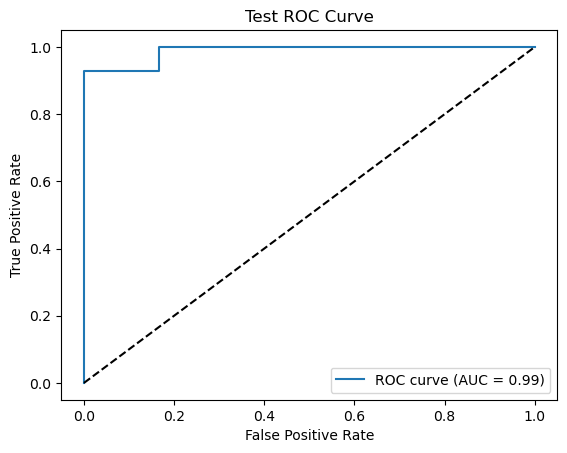

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

all_test_preds = []
all_test_labels = []
all_test_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
print("\nTest Confusion Matrix:")
print(cm)

# Classification Report
print("\nTest Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names))

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)
auc = roc_auc_score(all_test_labels, all_test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc='lower right')
plt.show()

003d41dd20f271d27219fe7ee6de727d.jpg: 예측=minimal, 맥시멀 확률=0.93
0046f98599f05fd7233973e430d6d04d.jpg: 예측=minimal, 맥시멀 확률=1.00
004e9e21cd1aca568a8ffc77a54638ce.jpg: 예측=minimal, 맥시멀 확률=0.98
005b37fce3c0f641d327d95dd832f51b.jpg: 예측=maximal, 맥시멀 확률=0.40
0094940c58c343b742f48ae26eb5e9fa.jpg: 예측=minimal, 맥시멀 확률=1.00
0099bc6cd3b8c47c2d21a2877b1fa533.jpg: 예측=maximal, 맥시멀 확률=0.18
009b107156c1ee41b03c5b35a82e7232.jpg: 예측=maximal, 맥시멀 확률=0.13
00a1940434d687a785be0acf2b0fbff3.jpg: 예측=minimal, 맥시멀 확률=1.00
00a325fd4dc22079095ab46330abf7be.jpg: 예측=maximal, 맥시멀 확률=0.20
00a8764cff12b2e849c850f4be5608bc.jpg: 예측=maximal, 맥시멀 확률=0.00
